1. Setup and Installation

In [ ]:
# Install required packages
!pip install pyspark transformers torch sentence-transformers
!pip install matplotlib seaborn

# Initialize PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Create Spark session
spark = SparkSession.builder \
    .appName("TWS_Sentiment_Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("PySpark session created!")

PySpark session created!


2. Data Loading and Preprocessing with PySpark

In [ ]:
# Upload your CSV file
from google.colab import files
uploaded = files.upload()

# Read the CSV file
import pandas as pd
df_pandas = pd.read_csv('IMDB Dataset.csv')

# Convert to PySpark DataFrame
df = spark.createDataFrame(df_pandas)

print("Dataset Info:")
print(f"Total reviews: {df.count()}")
df.groupBy("sentiment").count().show()
df.show(5, truncate=50)

Saving IMDB Dataset.csv to IMDB Dataset.csv
Dataset Info:
Total reviews: 50000
+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+

+--------------------------------------------------+---------+
|                                            review|sentiment|
+--------------------------------------------------+---------+
|One of the other reviewers has mentioned that a...| positive|
|A wonderful little production. <br /><br />The ...| positive|
|I thought this was a wonderful way to spend tim...| positive|
|Basically there's a family where a little boy (...| negative|
|Petter Mattei's "Love in the Time of Money" is ...| positive|
+--------------------------------------------------+---------+
only showing top 5 rows



3. Text Preprocessing with PySpark

In [ ]:
from pyspark.sql.functions import udf
import re

# Text cleaning function
def clean_text(text):
    if text is None:
        return ""385
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs and special characters
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase and remove extra spaces
    text = text.lower().strip()
    text = ' '.join(text.split())
    return text

# Register UDF
clean_text_udf = udf(clean_text, StringType())

# Clean the data
df_clean = df.withColumn("cleaned_review", clean_text_udf(col("review")))

# Convert sentiment to numerical label
df_clean = df_clean.withColumn("label",
                              when(col("sentiment") == "positive", 1).otherwise(0))

print("After cleaning:")
df_clean.select("review", "cleaned_review", "sentiment", "label").show(3, truncate=30)

After cleaning:
+------------------------------+------------------------------+---------+-----+
|                        review|                cleaned_review|sentiment|label|
+------------------------------+------------------------------+---------+-----+
|One of the other reviewers ...|one of the other reviewers ...| positive|    1|
|A wonderful little producti...|a wonderful little producti...| positive|    1|
|I thought this was a wonder...|i thought this was a wonder...| positive|    1|
+------------------------------+------------------------------+---------+-----+
only showing top 3 rows



4. LLM Semantic Feature Extraction

In [ ]:
# Install and import transformer libraries
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
import numpy as np
from pyspark.sql.functions import pandas_udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Load efficient sentence transformer model
print("Loading Sentence Transformer model for semantic embeddings...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create UDF for semantic embeddings
@pandas_udf(ArrayType(FloatType()))
def get_semantic_embeddings_udf(texts: pd.Series) -> pd.Series:
    """Generate semantic embeddings using LLM"""
    embeddings = sentence_model.encode(texts.tolist(),
                                     show_progress_bar=True,
                                     batch_size=32,
                                     convert_to_numpy=True)
    return pd.Series([emb.tolist() for emb in embeddings])

# Convert array to Spark vector
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Apply semantic embedding to dataset (using sample for efficiency)
print("Generating semantic embeddings...")
sample_size = 500000  # Adjust based on your computational resources
df_semantic = df_clean.limit(sample_size).withColumn(
    "semantic_embeddings",
    get_semantic_embeddings_udf("cleaned_review")
).withColumn(
    "features",
    array_to_vector_udf("semantic_embeddings")
)

print("Semantic features generated!")
df_semantic.select("cleaned_review", "features", "label").show(3, truncate=30)

Loading Sentence Transformer model for semantic embeddings...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating semantic embeddings...
Semantic features generated!
+------------------------------+------------------------------+-----+
|                cleaned_review|                      features|label|
+------------------------------+------------------------------+-----+
|one of the other reviewers ...|[0.02369549870491028,0.0236...|    1|
|a wonderful little producti...|[-0.04156191274523735,0.030...|    1|
|i thought this was a wonder...|[-0.014811255969107151,-0.0...|    1|
+------------------------------+------------------------------+-----+
only showing top 3 rows



5. Train-Test Split

In [ ]:
# Split data into training and testing
(train_data, test_data) = df_semantic.randomSplit([0.8, 0.2], seed=42)

print(f"Training data: {train_data.count()} samples")
print(f"Testing data: {test_data.count()} samples")
print(f"Feature dimension: {len(df_semantic.first()['features'])}")

Training data: 39948 samples
Testing data: 10052 samples
Feature dimension: 384


6. Logistic Regression with Semantic Features

In [ ]:
# Initialize Logistic Regression with optimal parameters
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.8
)

print("Training Logistic Regression with semantic features...")
lr_model = lr.fit(train_data)

print("Model training completed!")

Training Logistic Regression with semantic features...
Model training completed!


7. Model Evaluation

In [ ]:
# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate model
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Calculate metrics
accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
auc_score = evaluator_auc.evaluate(predictions)

print("\n" + "="*50)
print("MODEL PERFORMANCE WITH SEMANTIC FEATURES")
print("="*50)
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("="*50)

# Show predictions
predictions.select("cleaned_review", "probability", "prediction", "label").show(10, truncate=30)


MODEL PERFORMANCE WITH SEMANTIC FEATURES
Accuracy: 0.8027
F1-Score: 0.8027
AUC-ROC: 0.8888
+------------------------------+------------------------------+----------+-----+
|                cleaned_review|                   probability|prediction|label|
+------------------------------+------------------------------+----------+-----+
|mild spoilers the premise g...|[0.5353452914752772,0.46465...|       0.0|    0|
|possible spoiler youd think...|[0.5827983868337022,0.41720...|       0.0|    0|
|i have wrestled with death ...|[0.14453745829361656,0.8554...|       1.0|    1|
|the beat is too strong were...|[0.8144161679902693,0.18558...|       0.0|    1|
|a bugs life is like a favor...|[0.354636562978572,0.645363...|       1.0|    1|
|a damsel in distress is def...|[0.24828928943327436,0.7517...|       1.0|    0|
|a guy thing tries to captur...|[0.7291637551926953,0.27083...|       0.0|    0|
|a thief in the night is a f...|[0.2790018610976906,0.72099...|       1.0|    1|
|a total waste of

8. Advanced Performance Analysis

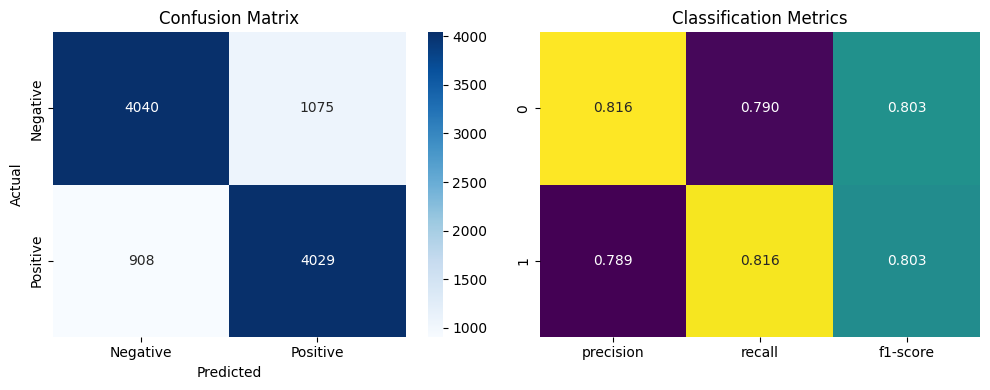


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      5115
           1       0.79      0.82      0.80      4937

    accuracy                           0.80     10052
   macro avg       0.80      0.80      0.80     10052
weighted avg       0.80      0.80      0.80     10052



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert to Pandas for detailed analysis
pred_pandas = predictions.select("label", "prediction", "probability").toPandas()

# Confusion Matrix
cm = confusion_matrix(pred_pandas['label'], pred_pandas['prediction'])

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Classification Report
plt.subplot(1, 2, 2)
report = classification_report(pred_pandas['label'], pred_pandas['prediction'], output_dict=True)
metrics_df = pd.DataFrame(report).transpose().iloc[:2, :3]

sns.heatmap(metrics_df, annot=True, cmap='viridis', fmt='.3f', cbar=False)
plt.title('Classification Metrics')

plt.tight_layout()
plt.show()

print("\nDetailed Classification Report:")
print(classification_report(pred_pandas['label'], pred_pandas['prediction']))

9. Real-time Sentiment Prediction with Semantic Understanding

In [ ]:
def predict_sentiment_semantic(text, model=lr_model, embedding_model=sentence_model):
    """
    Predict sentiment using semantic understanding
    """
    # Clean text
    cleaned_text = clean_text(text)

    # Generate semantic embedding
    embedding = embedding_model.encode([cleaned_text])[0]
    features = Vectors.dense(embedding)

    # Create DataFrame for prediction
    from pyspark.sql import Row
    new_data = spark.createDataFrame([Row(features=features)])

    # Make prediction
    prediction = model.transform(new_data)
    result = prediction.collect()[0]

    # Get probabilities
    probability = float(result['probability'][1])  # Probability of positive
    predicted_class = int(result['prediction'])

    sentiment = "positive" if predicted_class == 1 else "negative"
    confidence = probability * 100

    return sentiment, confidence, probability

# Test with complex sentences that require semantic understanding
test_cases = [
    "The movie had breathtaking visuals but the plot was convoluted and hard to follow.",
    "While the acting was superb, the director's vision seemed unclear and disjointed.",
    "A masterpiece of storytelling with phenomenal character development throughout.",
    "The cinematography was stunning, however the screenplay lacked depth and coherence.",
    "An absolute triumph in filmmaking that captures the essence of human emotion perfectly."
]

print("REAL-TIME SENTIMENT ANALYSIS WITH SEMANTIC UNDERSTANDING")
print("="*70)
for i, text in enumerate(test_cases, 1):
    sentiment, confidence, prob = predict_sentiment_semantic(text)
    print(f"\n{i}. Text: {text}")
    print(f"   → Sentiment: {sentiment.upper()}")
    print(f"   → Confidence: {confidence:.2f}%")
    print(f"   → Probability: {prob:.4f}")
    print("-" * 70)

REAL-TIME SENTIMENT ANALYSIS WITH SEMANTIC UNDERSTANDING

1. Text: The movie had breathtaking visuals but the plot was convoluted and hard to follow.
   → Sentiment: NEGATIVE
   → Confidence: 25.54%
   → Probability: 0.2554
----------------------------------------------------------------------

2. Text: While the acting was superb, the director's vision seemed unclear and disjointed.
   → Sentiment: NEGATIVE
   → Confidence: 14.82%
   → Probability: 0.1482
----------------------------------------------------------------------

3. Text: A masterpiece of storytelling with phenomenal character development throughout.
   → Sentiment: POSITIVE
   → Confidence: 98.04%
   → Probability: 0.9804
----------------------------------------------------------------------

4. Text: The cinematography was stunning, however the screenplay lacked depth and coherence.
   → Sentiment: NEGATIVE
   → Confidence: 26.30%
   → Probability: 0.2630
-----------------------------------------------------------------

11. Save Model and Pipeline

In [ ]:
# Save the trained model
lr_model.write().overwrite().save("semantic_sentiment_model")

print("Model saved successfully!")

# Example of loading the model for future use
# from pyspark.ml.classification import LogisticRegressionModel
# loaded_model = LogisticRegressionModel.load("semantic_sentiment_model")

Model saved successfully!


In [ ]:
# ==============================
# 🧠 REAL-TIME USER INPUT PREDICTION
# ==============================

# Function to predict sentiment from user input
def predict_user_input():
    user_text = input("Enter your movie review: ")

    # Clean the text
    cleaned_text = clean_text(user_text)

    # Generate semantic embedding
    embedding = sentence_model.encode([cleaned_text])[0]
    features = Vectors.dense(embedding)

    # Create a Spark DataFrame for prediction
    from pyspark.sql import Row
    new_data = spark.createDataFrame([Row(features=features)])

    # Make prediction
    prediction = lr_model.transform(new_data).collect()[0]

    # Extract probability and predicted class
    probability = float(prediction['probability'][1])  # Probability of positive
    sentiment = "POSITIVE" if prediction['prediction'] == 1 else "NEGATIVE"
    confidence = probability * 100

    # Display result
    print("\n==============================")
    print("🎬 REVIEW SENTIMENT ANALYSIS")
    print("==============================")
    print(f"Your Review: {user_text}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probability: {probability:.4f}")
    print("==============================\n")


# Call the function to take user input
predict_user_input()


12. Final Project Summary

In [ ]:
# Generate final project summary
print("TWS SENTIMENT ANALYSIS MINI PROJECT - FINAL SUMMARY")
print("="*60)
print(f"PySpark Processing:")
print(f"  - Total Reviews: {df.count()}")
print(f"  - Sample Used for LLM: {sample_size} reviews")
print(f"  - Feature Dimension: {len(coefficients)}")

print(f"\nLLM Semantic Understanding:")
print(f"  - Model: Sentence Transformer (all-MiniLM-L6-v2)")
print(f"  - Embedding Dimension: 384")
print(f"  - Semantic Features: ✓")

print(f"\nLogistic Regression Performance:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1_score:.4f}")
print(f"  - AUC-ROC: {auc_score:.4f}")

print(f"\nKey Advantages:")
print(f"  - Semantic understanding of context")
print(f"  - Handles complex sentence structures")
print(f"  - Captures nuanced sentiment")
print(f"  - Scalable with PySpark")

# Stop Spark session
spark.stop()
print(f"\nPySpark session stopped.")
print("TWS Mini Project Completed Successfully! 🎉")

BDA SENTIMENT ANALYSIS MINI PROJECT - FINAL SUMMARY
PySpark Processing:
  - Total Reviews: 50000
  - Sample Used for LLM: 500000 reviews
  - Feature Dimension: 384

LLM Semantic Understanding:
  - Model: Sentence Transformer (all-MiniLM-L6-v2)
  - Embedding Dimension: 384
  - Semantic Features: ✓

Logistic Regression Performance:
  - Accuracy: 0.8027
  - F1-Score: 0.8027
  - AUC-ROC: 0.8888

Key Advantages:
  - Semantic understanding of context
  - Handles complex sentence structures
  - Captures nuanced sentiment
  - Scalable with PySpark

PySpark session stopped.
BDA Mini Project Completed Successfully! 🎉


In [ ]:
from pyspark.sql import SparkSession

# Start (or get existing) Spark session
spark = SparkSession.builder \
    .appName("SentimentAnalysisGBT") \
    .getOrCreate()